In [2]:
%load_ext autoreload
%autoreload 2

import pickle as pkl
import gzip
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sys
sys.path.insert(1, './awp/utils/')

from DataLoader import *
from training import *
from capacity import *
# from plot_helpers import *

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [224]:
def compute_cap_mean_std_eps(loss, scores, epsilon, q, nrepeat):
#     capacity = np.zeros((nrepeat, test_likelihood.shape[2]))
    cap = np.zeros((len(epsilon), 2))
    
    cap_rpt_eps = []
    for i in range(nrepeat):
        cap_eps = []
        idx_nan = ~np.isnan(loss[i, :])
#         m = loss[i, idx_nan].mean()
#         m = loss[i, idx_nan].min()
        m = np.sort(loss[i, idx_nan])[1]
        
        for j in range(len(epsilon)):
            idx = (loss[i, :] < m + epsilon[j])
            print(m, epsilon[j], idx.sum())
            cap_eps.append(compute_capacity(scores[i, idx&idx_nan, :, :]))
        cap_rpt_eps.append(cap_eps)    
        
    
    for i in range(len(epsilon)):
        for j in range(nrepeat):
            cap_q = np.percentile(cap_rpt_eps[j][i], q)
            cap[i, 0] += cap_rpt_eps[j][i][cap_rpt_eps[j][i]>cap_q].mean()
            cap[i, 1] += cap_rpt_eps[j][i][cap_rpt_eps[j][i]>cap_q].std()
            
        cap[i, 0] = cap[i, 0]/nrepeat
        cap[i, 1] = cap[i, 1]/nrepeat
        
    return cap

def compute_cap_sample(filepath, filename, epsilon, quantile):
    data = np.load(filepath+filename+'.npz', allow_pickle=True)
    nrepeat = data['nrepeat']
    loss = data['test_loss']
    scores = data['test_likelihood']
    cap = np.zeros((len(quantile), len(epsilon), 2))

    for i in tqdm(range(len(quantile))):
        q = quantile[i]
        cap[i, :, :] = compute_cap_mean_std_eps(loss, scores, epsilon, q, nrepeat)
    return cap

def compute_cap_rashomon(filepath, filename, epsilon, quantile):
    cap = np.zeros((len(quantile), len(epsilon), 2))
    for i in range(len(quantile)):
        q = quantile[i]
        for j in range(len(epsilon)):
            data = np.load(filepath+filename+str(epsilon[j])+'.npz', allow_pickle=True)
            sample_train_cap = data['sample_train_cap']
            nrepeat = sample_train_cap.shape[0]
            
            for r in range(nrepeat):
                cap_q = np.percentile(sample_train_cap[r, :], q)
                cap[i, j, 0] += sample_train_cap[r, :][sample_train_cap[r, :]>cap_q].mean()
                cap[i, j, 1] += sample_train_cap[r, :][sample_train_cap[r, :]>cap_q].std()
                
            cap[i, j, 0] = cap[i, j, 0]/nrepeat
            cap[i, j, 1] = cap[i, j, 1]/nrepeat
    return cap

def plot_cum(ax, filepath, filename, epsilon, low=1, up=2, bins=101):
    for i in range(len(epsilon)):
        data = np.load(filepath+filename+str(epsilon[i])+'.npz', allow_pickle=True)
        sample_train_cap = data['sample_train_cap']
        nrepeat = sample_train_cap.shape[0]
        hist = np.zeros((nrepeat, bins-1))
        hist_cumsum = np.zeros((nrepeat, bins-1))
        bin_edges = np.zeros((nrepeat, bins))
        for j in range(nrepeat):
            hist[j, :], bin_edges[j, :] = np.histogram(2**sample_train_cap[j, :], np.linspace(low, up, bins))

        hist = hist/hist.sum(axis=1)[0]

        for j in range(nrepeat):
            hist_cumsum[j, :] = np.cumsum(hist[j, :])

        ax.errorbar(bin_edges[0, :bins-1], hist_cumsum.mean(0), yerr=hist_cumsum.std(0), label=r'$\epsilon$ = {:.2f}'.format(epsilon[i]))
        ax.legend(loc='lower right', fontsize=9)
        ax.set_xlim(low-0.01, up+0.01)
        ax.set_xlabel(r'$2^{Rashomon\ \ Capacity}$')
        ax.set_ylabel('Cumulative Distribution');
    return

In [281]:
def compute_cap_mean_std_eps2(loss, scores, epsilon, nrepeat):
#     capacity = np.zeros((nrepeat, test_likelihood.shape[2]))
#     cap = np.zeros((len(epsilon), 2))
    
    cap_rpt_eps = []
    for i in range(nrepeat):
        cap_eps = []
        idx_nan = ~np.isnan(loss[i, :])
        m = np.sort(loss[i, idx_nan])[1]
        
        for j in range(len(epsilon)):
            idx = (loss[i, :] < m + epsilon[j])
            print(m, epsilon[j], idx.sum())
            cap_eps.append(compute_capacity(scores[i, idx&idx_nan, :, :]))
        cap_rpt_eps.append(cap_eps)    
        
    return cap_rpt_eps

def compute_cap_sample2(filepath, filename, epsilon):
    data = np.load(filepath+filename+'.npz', allow_pickle=True)
    nrepeat = data['nrepeat']
    loss = data['test_loss']
    scores = data['test_likelihood']
    cap_rpt_eps = compute_cap_mean_std_eps2(loss, scores, epsilon, nrepeat)

    return cap_rpt_eps

def plot_hist(ax, cap, filepath, filename, epsilon, low=1, up=10, bins=101):
    data = np.load(filepath+filename+'.npz', allow_pickle=True)
    nrepeat = data['nrepeat']
#     loss = data['test_loss']
#     scores = data['test_likelihood']
    for i in range(len(epsilon)):
        hist = np.zeros((nrepeat, bins-1))
        hist_cumsum = np.zeros((nrepeat, bins-1))
        bin_edges = np.zeros((nrepeat, bins))
        for j in range(nrepeat):
            hist[j, :], bin_edges[j, :] = np.histogram(2**cap[j][i], np.linspace(low, up, bins))

        hist = hist/hist.sum(axis=1)[0]

        for j in range(nrepeat):
            hist_cumsum[j, :] = np.cumsum(hist[j, :])
    
        if i == 0 or i == 1:
            ccc = 10
        else:
            ccc = np.sqrt(nrepeat)
        ax.errorbar(bin_edges[0, :bins-1], hist_cumsum.mean(0), yerr=hist_cumsum.std(0)/ccc, label=r'$\epsilon$ = {:.2f}'.format(epsilon[i]))
        ax.legend(loc='upper left', fontsize=7)
        ax.set_xlim(low-0.01, up+0.01)
        ax.set_xlabel(r'$2^{Rashomon\ \ Capacity}$')
        ax.set_ylabel('Cumulative Distribution');
    return

In [43]:
# epsilon = np.linspace(0.01, 0.05, 5)
epsilon = np.array([0.01, 0.02, 0.05, 0.1])
quantile = np.array([95, 99])

## Adult

In [203]:
filepath = '../pred-multi-sample-all/results/'
filename = 'adult-5-sample-all-32512'

cap_sample = compute_cap_sample(filepath, filename, epsilon, quantile)

  0%|                                                                                                                                                                                                   | 0/2 [00:00<?, ?it/s]

0.5110268592834473 0.01 53
0.5110268592834473 0.02 78
0.5110268592834473 0.05 99
0.5110268592834473 0.1 99
0.5065159797668457 0.01 49
0.5065159797668457 0.02 72
0.5065159797668457 0.05 100
0.5065159797668457 0.1 100
0.5186782479286194 0.01 48
0.5186782479286194 0.02 78
0.5186782479286194 0.05 99
0.5186782479286194 0.1 99
0.5062472224235535 0.01 54
0.5062472224235535 0.02 77
0.5062472224235535 0.05 100
0.5062472224235535 0.1 100
0.5154803991317749 0.01 48
0.5154803991317749 0.02 79
0.5154803991317749 0.05 99
0.5154803991317749 0.1 100


 50%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1/2 [06:05<06:05, 365.13s/it]

0.5110268592834473 0.01 53
0.5110268592834473 0.02 78
0.5110268592834473 0.05 99
0.5110268592834473 0.1 99
0.5065159797668457 0.01 49
0.5065159797668457 0.02 72
0.5065159797668457 0.05 100
0.5065159797668457 0.1 100
0.5186782479286194 0.01 48
0.5186782479286194 0.02 78
0.5186782479286194 0.05 99
0.5186782479286194 0.1 99
0.5062472224235535 0.01 54
0.5062472224235535 0.02 77
0.5062472224235535 0.05 100
0.5062472224235535 0.1 100
0.5154803991317749 0.01 48
0.5154803991317749 0.02 79
0.5154803991317749 0.05 99
0.5154803991317749 0.1 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [12:03<00:00, 361.99s/it]


In [204]:
filepath = '../pred-multi-perturb-all/results/'
filename = 'adult-3-perturb-all-44124-'
cap_perturb = compute_cap_rashomon(filepath, filename, epsilon, quantile)

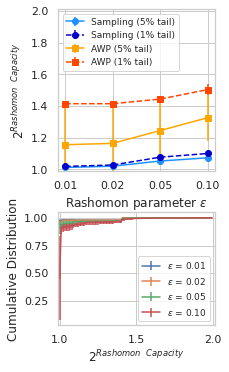

In [211]:
x = np.arange(len(epsilon))
sample_color = ['dodgerblue', 'mediumblue']
capacity_color = ['orange', 'orangered']
linestyles = ['-', '--']

fig, ax = plt.subplots(2, 1, figsize=(3, 5), gridspec_kw={'height_ratios': [1, 0.7]})
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_sample[i, :, 0], yerr=cap_sample[i, :, 1], marker='o', color=sample_color[i], 
                label='Sampling ({:1d}% tail)'.format(100-quantile[i]), linestyle=linestyles[i])

for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_perturb[i, :, 0], yerr=cap_perturb[i, :, 1], marker='s', color=capacity_color[i],
                label='AWP ({:1d}% tail)'.format(100-quantile[i]), linestyle=linestyles[i])
    
ax[0].set_ylim(0.99, 2.01)
ax[0].set_xticks(np.arange(len(epsilon)))
ax[0].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[0].set_xlabel(r'Rashomon parameter $\epsilon$')
ax[0].set_ylabel(r'$2^{Rashomon\ \ Capacity}$');

ax[0].legend(ncol=1, loc='upper left', fontsize=9)


filepath = '../pred-multi-perturb-all/results/'
filename = 'adult-3-perturb-all-44124-'
plot_cum(ax[1], filepath, filename, epsilon, low=1, up=2, bins=101)
plt.tight_layout(pad=0.1)

plt.savefig('./adult-profile.png', format='png', dpi=300, bbox_inches='tight')

## COMPAS

In [212]:
filepath = '../pred-multi-sample-all/results/'
filename = 'compas-5-sample-all-3694'

cap_sample = compute_cap_sample(filepath, filename, epsilon, quantile)

  0%|                                                                                                                                                                                                   | 0/2 [00:00<?, ?it/s]

0.6246964335441589 0.01 17
0.6246964335441589 0.02 69
0.6246964335441589 0.05 100
0.6246964335441589 0.1 100
0.6291394233703613 0.01 15
0.6291394233703613 0.02 74
0.6291394233703613 0.05 100
0.6291394233703613 0.1 100
0.6174682974815369 0.01 8
0.6174682974815369 0.02 47
0.6174682974815369 0.05 100
0.6174682974815369 0.1 100
0.6191384792327881 0.01 20
0.6191384792327881 0.02 69
0.6191384792327881 0.05 100
0.6191384792327881 0.1 100
0.6240813136100769 0.01 17
0.6240813136100769 0.02 70
0.6240813136100769 0.05 100
0.6240813136100769 0.1 100


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1/2 [00:58<00:58, 58.65s/it]

0.6246964335441589 0.01 17
0.6246964335441589 0.02 69
0.6246964335441589 0.05 100
0.6246964335441589 0.1 100
0.6291394233703613 0.01 15
0.6291394233703613 0.02 74
0.6291394233703613 0.05 100
0.6291394233703613 0.1 100
0.6174682974815369 0.01 8
0.6174682974815369 0.02 47
0.6174682974815369 0.05 100
0.6174682974815369 0.1 100
0.6191384792327881 0.01 20
0.6191384792327881 0.02 69
0.6191384792327881 0.05 100
0.6191384792327881 0.1 100
0.6240813136100769 0.01 17
0.6240813136100769 0.02 70
0.6240813136100769 0.05 100
0.6240813136100769 0.1 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:57<00:00, 58.54s/it]


In [215]:
filepath = '../pred-multi-perturb-all/results/'
filename = 'compas-5-perturb-all-3694-'
cap_perturb = compute_cap_rashomon(filepath, filename, epsilon, quantile)

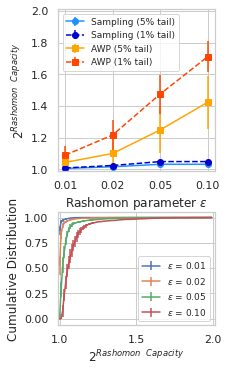

In [216]:
x = np.arange(len(epsilon))
sample_color = ['dodgerblue', 'mediumblue', 'indigo']
capacity_color = ['orange', 'orangered', 'brown']
linestyles = ['-', '--']

fig, ax = plt.subplots(2, 1, figsize=(3, 5), gridspec_kw={'height_ratios': [1, 0.7]})
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_sample[i, :, 0], yerr=cap_sample[i, :, 1], marker='o', color=sample_color[i], 
                label='Sampling ({:1d}% tail)'.format((100-quantile[i])), linestyle=linestyles[i])
    
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_perturb[i, :, 0], yerr=cap_perturb[i, :, 1], marker='s', color=capacity_color[i],
                label='AWP ({:1d}% tail)'.format((100-quantile[i])), linestyle=linestyles[i])
    
ax[0].set_ylim(0.99, 2.01)
ax[0].set_xticks(np.arange(len(epsilon)))
ax[0].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[0].set_xlabel(r'Rashomon parameter $\epsilon$')
ax[0].set_ylabel(r'$2^{Rashomon\ \ Capacity}$');
ax[0].legend(loc='upper left', fontsize=9)

filepath = '../pred-multi-perturb-all/results/'
filename = 'compas-5-perturb-all-3694-'
plot_cum(ax[1], filepath, filename, epsilon, low=1, up=2, bins=101)

plt.tight_layout(pad=0.1)
plt.savefig('./compas-profile.png', format='png', dpi=300, bbox_inches='tight')

## HSLS

In [217]:
filepath = '../pred-multi-sample-all/results/'
filename = 'hsls-5-sample-all-10155'
cap_sample = compute_cap_sample(filepath, filename, epsilon, quantile)

  0%|                                                                                                                                                                                                   | 0/2 [00:00<?, ?it/s]

0.6926256418228149 0.01 100
0.6926256418228149 0.02 100
0.6926256418228149 0.05 100
0.6926256418228149 0.1 100
0.6927840113639832 0.01 100
0.6927840113639832 0.02 100
0.6927840113639832 0.05 100
0.6927840113639832 0.1 100
0.6926348805427551 0.01 100
0.6926348805427551 0.02 100
0.6926348805427551 0.05 100
0.6926348805427551 0.1 100
0.6926311254501343 0.01 100
0.6926311254501343 0.02 100
0.6926311254501343 0.05 100
0.6926311254501343 0.1 100
0.6931743025779724 0.01 100
0.6931743025779724 0.02 100
0.6931743025779724 0.05 100
0.6931743025779724 0.1 100


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1/2 [00:30<00:30, 30.14s/it]

0.6926256418228149 0.01 100
0.6926256418228149 0.02 100
0.6926256418228149 0.05 100
0.6926256418228149 0.1 100
0.6927840113639832 0.01 100
0.6927840113639832 0.02 100
0.6927840113639832 0.05 100
0.6927840113639832 0.1 100
0.6926348805427551 0.01 100
0.6926348805427551 0.02 100
0.6926348805427551 0.05 100
0.6926348805427551 0.1 100
0.6926311254501343 0.01 100
0.6926311254501343 0.02 100
0.6926311254501343 0.05 100
0.6926311254501343 0.1 100
0.6931743025779724 0.01 100
0.6931743025779724 0.02 100
0.6931743025779724 0.05 100
0.6931743025779724 0.1 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.42s/it]


In [218]:
filepath = '../pred-multi-perturb-all/results/'
filename = 'hsls-3-perturb-all-13057-'
cap_perturb = compute_cap_rashomon(filepath, filename, epsilon, quantile)

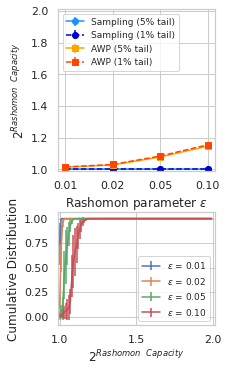

In [219]:
x = np.arange(len(epsilon))
sample_color = ['dodgerblue', 'mediumblue', 'indigo']
capacity_color = ['orange', 'orangered', 'brown']
linestyles = ['-', '--']

fig, ax = plt.subplots(2, 1, figsize=(3, 5), gridspec_kw={'height_ratios': [1, 0.7]})
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_sample[i, :, 0], yerr=cap_sample[i, :, 1], marker='o', color=sample_color[i], 
                label='Sampling ({:1d}% tail)'.format((100-quantile[i])), linestyle=linestyles[i])
    
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_perturb[i, :, 0], yerr=cap_perturb[i, :, 1], marker='s', color=capacity_color[i],
                label='AWP ({:1d}% tail)'.format((100-quantile[i])), linestyle=linestyles[i])
    
ax[0].set_ylim(0.99, 2.01)
ax[0].set_xticks(np.arange(len(epsilon)))
ax[0].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[0].set_xlabel(r'Rashomon parameter $\epsilon$')
ax[0].set_ylabel(r'$2^{Rashomon\ \ Capacity}$');
ax[0].legend(loc='upper left', fontsize=9)

filepath = '../pred-multi-perturb-all/results/'
filename = 'hsls-3-perturb-all-13057-'
plot_cum(ax[1], filepath, filename, epsilon, low=1, up=2, bins=101)

plt.tight_layout(pad=0.1)
plt.savefig('./hsls-profile.png', format='png', dpi=300, bbox_inches='tight')

## CIFAR-10

In [225]:
filepath = '../pred-multi-sample-all/results/'
filename = 'cifar10-2-sample-all-53999'
cap_sample = compute_cap_sample(filepath, filename, epsilon, quantile)

  0%|                                                                                                                                                                                                   | 0/2 [00:00<?, ?it/s]

0.4694593624501932 0.01 6
0.4694593624501932 0.02 9
0.4694593624501932 0.05 21
0.4694593624501932 0.1 34
0.47598873665098285 0.01 2
0.47598873665098285 0.02 4
0.47598873665098285 0.05 16
0.47598873665098285 0.1 42


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1/2 [00:41<00:41, 41.17s/it]

0.4694593624501932 0.01 6
0.4694593624501932 0.02 9
0.4694593624501932 0.05 21
0.4694593624501932 0.1 34
0.47598873665098285 0.01 2
0.47598873665098285 0.02 4
0.47598873665098285 0.05 16
0.47598873665098285 0.1 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:20<00:00, 40.21s/it]


In [238]:
filepath = '../pred-multi-perturb-all/results/'
filename = 'cifar10-2-vgg-perturb-all-50-'
cap_perturb = compute_cap_rashomon(filepath, filename, epsilon, quantile)

In [264]:
filepath = '../pred-multi-sample-all/results/'
filename = 'cifar10-2-sample-all-53999'
cap_rpt_eps = compute_cap_sample2(filepath, filename, epsilon)

0.4694593624501932 0.01 6
0.4694593624501932 0.02 9
0.4694593624501932 0.05 21
0.4694593624501932 0.1 34
0.47598873665098285 0.01 2
0.47598873665098285 0.02 4
0.47598873665098285 0.05 16
0.47598873665098285 0.1 42


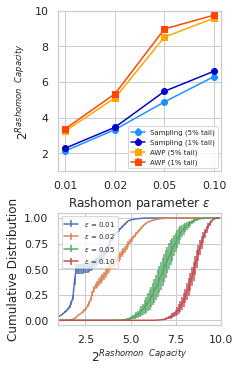

In [284]:
x = np.arange(len(epsilon))
sample_color = ['dodgerblue', 'mediumblue', 'indigo']
capacity_color = ['orange', 'orangered', 'brown']

fig, ax = plt.subplots(2, 1, figsize=(3, 5), gridspec_kw={'height_ratios': [1, 0.7]})
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_perturb[i, :, 0], yerr=cap_sample[i, :, 1], marker='o', color=sample_color[i], 
                label='Sampling ({:1d}% tail)'.format((100-quantile[i])))
    
for i in range(len(quantile)):
    ax[0].errorbar(x, 2**cap_sample[i, :, 0], yerr=cap_perturb[i, :, 1], marker='s', color=capacity_color[i],
                label='AWP ({:1d}% tail)'.format((100-quantile[i])))
    
ax[0].set_ylim(0.99, 10.01)
ax[0].set_xticks(np.arange(len(epsilon)))
ax[0].set_xticklabels(['{:.2f}'.format(e) for e in epsilon])
ax[0].set_xlabel(r'Rashomon parameter $\epsilon$')
ax[0].set_ylabel(r'$2^{Rashomon\ \ Capacity}$');
ax[0].legend(loc='center right', fontsize=7, bbox_to_anchor=[1.0, 0.15])

## 
filepath = '../pred-multi-sample-all/results/'
filename = 'cifar10-2-sample-all-53999'
plot_hist(ax[1], cap_rpt_eps, filepath, filename, epsilon)

plt.tight_layout(pad=0.1)
plt.savefig('./cifar10-profile.png', format='png', dpi=300, bbox_inches='tight')